# RCG-NET
#### This is made for Gender classification derived from ResNet50 Architecture

### Required Modules

In [5]:
# ✅ TensorFlow: Core library for building and training deep learning models
import tensorflow as tf

# ✅ Matplotlib: For visualizing training curves and image predictions
import matplotlib.pyplot as plt

# ✅ NumPy: For numerical operations on arrays and tensors
import numpy as np

# ✅ Preprocessing function specific to ResNet50 (e.g., mean subtraction, scaling)
from tensorflow.keras.applications.resnet50 import preprocess_input

# ✅ Glob: For fetching image file paths using wildcards (e.g., *.jpg)
import glob

# ✅ Layers API: Used for creating CNN, Dense, Pooling, Attention, etc.
from tensorflow.keras import layers

# ✅ Pretrained ResNet50 model (used as feature extractor or base model)
from tensorflow.keras.applications import ResNet50

# ✅ Redundant but valid — also importing layers directly again
from tensorflow.keras import layers

# ✅ Backend functions — advanced ops like K.int_shape, K.mean etc.
from tensorflow.keras import backend as K

# ✅ Base class for creating custom layers (e.g., CBAM, SE)
from tensorflow.keras.layers import Layer


### Suitable preprocessing of data According to ResNet50 Architecture

In [2]:
def preprocess_image(image_path):
    # 🔹 Step 1: Read the image file from the given path as a binary string
    image = tf.io.read_file(image_path)

    # 🔹 Step 2: Decode the JPEG-encoded image to a tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # 🔹 Step 3: Resize the image to 224x224 pixels to match the input size expected by ResNet50
    image = tf.image.resize(image, [224, 224])

    # 🔹 Step 4: Apply ResNet50-specific preprocessing (e.g., RGB mean subtraction & scaling)
    image = preprocess_input(image)

    # 🔹 Step 5: Return the preprocessed image tensor
    return image


In [3]:
# 🔹 Step 1: Load image file paths for each class (Male and Female) from training directory
male_train_paths = glob.glob("train/Male/*.jpg")
female_train_paths = glob.glob("train/Female/*.jpg")

# 🔹 Step 2: Preprocess each image using a defined preprocessing function (resizing, normalization)
male_train_images = [preprocess_image(p) for p in male_train_paths]
female_train_images = [preprocess_image(p) for p in female_train_paths]

# 🔹 Step 3: Convert the list of images into TensorFlow tensors for model consumption
male_train_images = tf.stack(male_train_images)
female_train_images = tf.stack(female_train_images)

# 🔹 Step 4: Create binary labels — 1 for Male, 0 for Female
male_train_labels = tf.ones(len(male_train_images), dtype=tf.int32)
female_train_labels = tf.zeros(len(female_train_images), dtype=tf.int32)

# 🔹 Step 5: Merge the male and female image tensors and corresponding labels
train_images = tf.concat([male_train_images, female_train_images], axis=0)
train_labels = tf.concat([male_train_labels, female_train_labels], axis=0)

# 🔹 Step 6: Create a tf.data.Dataset object from the combined images and labels
# 🔹 Step 7: Shuffle the data to ensure randomness, batch it, and prefetch for performance
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=42)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [4]:
# 🔹 Step 1: Load image file paths for each class (Male and Female) from validation directory
male_val_paths = glob.glob("val/Male/*.jpg")
female_val_paths = glob.glob("val/Female/*.jpg")

# 🔹 Step 2: Preprocess each image using a defined preprocessing function (resizing, normalization)
male_val_images = [preprocess_image(p) for p in male_val_paths]
female_val_images = [preprocess_image(p) for p in female_val_paths]

# 🔹 Step 3: Convert the list of images into TensorFlow tensors for model compatibility
male_val_images = tf.stack(male_val_images)
female_val_images = tf.stack(female_val_images)

# 🔹 Step 4: Create binary labels — 1 for Male, 0 for Female
male_val_labels = tf.ones(len(male_val_images), dtype=tf.int32)
female_val_labels = tf.zeros(len(female_val_images), dtype=tf.int32)

# 🔹 Step 5: Merge the male and female image tensors and corresponding labels
val_images = tf.concat([male_val_images, female_val_images], axis=0)
val_labels = tf.concat([male_val_labels, female_val_labels], axis=0)

# 🔹 Step 6: Create a tf.data.Dataset object from the combined images and labels
# 🔹 Step 7: Shuffle the validation data, batch it, and prefetch for efficient GPU/TPU usage
BATCH_SIZE = 16
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.shuffle(buffer_size=1024, seed=42)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Attention-Augmented CNN Head: SE Block and CBAM Integration over ResNet50

In [8]:
def se_block(input_tensor, reduction=16):
    """
    Implements a Squeeze-and-Excitation (SE) block.
    
    Args:
        input_tensor: Input feature map (batch, H, W, C)
        reduction: Reduction ratio for the intermediate Dense layer (usually 16)
    
    Returns:
        Output tensor after channel-wise reweighting
    """
    
    # Get number of channels from the input tensor shape
    channels = input_tensor.shape[-1]

    # === SQUEEZE ===
    # Global Average Pooling across spatial dimensions (H, W) → shape becomes (batch, C)
    x = layers.GlobalAveragePooling2D()(input_tensor)

    # === EXCITATION ===
    # Fully connected layer with reduction to bottleneck the channel dimension
    x = layers.Dense(channels // reduction, activation='relu')(x)

    # Restore back to original number of channels using sigmoid for weights (between 0 and 1)
    x = layers.Dense(channels, activation='sigmoid')(x)

    # Reshape to match dimensions for broadcasting → (batch, 1, 1, C)
    x = layers.Reshape((1, 1, channels))(x)

    # === SCALE ===
    # Multiply channel-wise weights with the original input tensor
    return layers.Multiply()([input_tensor, x])


In [9]:
class CBAM(Layer):
    def __init__(self, reduction=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.reduction = reduction  # Channel reduction ratio for bottleneck MLP

    def build(self, input_shape):
        self.channels = input_shape[-1]  # Number of channels in input

        # === Shared MLP for Channel Attention ===
        # Applies to both average and max pooled vectors
        self.shared_dense = tf.keras.Sequential([
            layers.Dense(self.channels // self.reduction, activation='relu'),
            layers.Dense(self.channels)
        ])

        # === Spatial Attention Convolution ===
        # 7x7 conv layer with sigmoid activation to get spatial attention map
        self.spatial_conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # ===== CHANNEL ATTENTION =====
        # Global average and max pooling to generate descriptors
        avg_pool = layers.GlobalAveragePooling2D()(inputs)  # shape: (batch, C)
        max_pool = layers.GlobalMaxPooling2D()(inputs)      # shape: (batch, C)

        # Apply shared MLP to both
        avg_out = self.shared_dense(avg_pool)  # shape: (batch, C)
        max_out = self.shared_dense(max_pool)  # shape: (batch, C)

        # Combine and apply sigmoid activation to get channel attention weights
        channel = layers.Add()([avg_out, max_out])            # shape: (batch, C)
        channel = layers.Activation('sigmoid')(channel)
        channel = layers.Reshape((1, 1, self.channels))(channel)  # reshape for broadcasting

        # Apply channel attention
        x = layers.Multiply()([inputs, channel])  # shape: (batch, H, W, C)

        # ===== SPATIAL ATTENTION =====
        # Average and max pooling along the channel axis
        avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)  # shape: (batch, H, W, 1)
        max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)   # shape: (batch, H, W, 1)

        # Concatenate along channel dimension
        spatial = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])  # shape: (batch, H, W, 2)

        # Apply spatial attention convolution
        spatial = self.spatial_conv(spatial)  # shape: (batch, H, W, 1)

        # Multiply input with spatial attention map
        return layers.Multiply()([x, spatial])  # Final output after CBAM


In [10]:
# 🔹 Step 1: Load the pre-trained ResNet50 model without the top classification layer
# Using ImageNet weights and setting input size to (224, 224, 3) for RGB images
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# 🔹 Step 2: Freeze the base model so the pretrained weights are not updated during training
base_model.trainable = False

# 🔹 Step 3: Extract the output feature map from the base model
x = base_model.output

# 🔹 Step 4: Add custom convolutional block to introduce learnable features
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# 🔹 Step 5: Apply Squeeze-and-Excitation (SE) block for channel-wise attention
x = se_block(x)

# 🔹 Step 6: Apply CBAM (Convolutional Block Attention Module) for combined channel + spatial attention
x = CBAM()(x)

# 🔹 Step 7: Add another Conv2D layer to further refine extracted features
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# 🔹 Step 8: Apply Global Average Pooling to reduce spatial dimensions to a single vector
x = layers.GlobalAveragePooling2D()(x)

# 🔹 Step 9: Add a dense fully connected layer with dropout for regularization
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# 🔹 Step 10: Output layer with sigmoid activation for binary classification (Male/Female)
output = layers.Dense(1, activation='sigmoid')(x)

# 🔹 Step 11: Combine the base model input and custom output head into a final model
model = tf.keras.Model(inputs=base_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step 



### Model compilation & training

In [12]:
# 🔧 Compile the model before training
model.compile(
    optimizer='adam',                      # 🔹 Optimizer: Adam combines the benefits of RMSProp and SGD with momentum
    loss='binary_crossentropy',            # 🔹 Loss Function: Suitable for binary classification (Male vs Female)
    metrics=['accuracy']                   # 🔹 Evaluation Metric: Track accuracy during training and validation
)


In [13]:
# 📊 Function to plot training and validation accuracy over epochs
def plot_full_training_curves(history):
    metrics = ['accuracy']  # Define metrics to plot
    val_metrics = [f"val_{m}" for m in metrics]  # Corresponding validation metrics

    plt.figure(figsize=(16, 12))  # Set the overall figure size

    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)  # Create subplot for each metric
        plt.plot(history.history[metric], label=f'Train {metric}', marker='o')  # Plot training metric
        
        # Plot validation metric if available
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}', marker='x')

        plt.title(f'{metric.upper()} per Epoch')  # Title of the plot
        plt.xlabel('Epochs')                      # Label x-axis
        plt.ylabel(metric.capitalize())           # Label y-axis
        plt.legend()                              # Show legend
        plt.grid()                                # Add grid lines for clarity

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()          # Display the plots


Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8793 - loss: 0.3465 - val_accuracy: 0.8578 - val_loss: 0.3442
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9560 - loss: 0.1332 - val_accuracy: 0.8555 - val_loss: 0.3474
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9473 - loss: 0.1414 - val_accuracy: 0.8957 - val_loss: 0.2742
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9689 - loss: 0.0899 - val_accuracy: 0.8555 - val_loss: 0.3066
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9739 - loss: 0.0891 - val_accuracy: 0.8507 - val_loss: 0.3868
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9765 - loss: 0.0713 - val_accuracy: 0.8957 - val_loss: 0.3662
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9887 - loss: 0.0337 - val_accuracy: 0.8768 - val_loss: 0.4517
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9831 - loss: 0.0588 - 

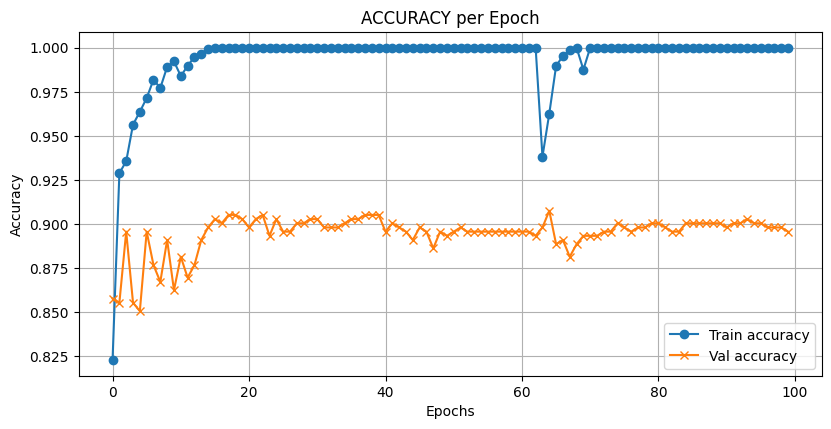

In [14]:
# 🚀 Train the model
history = model.fit(
    train_dataset,               # 🧠 Training dataset (images + labels)
    validation_data=val_dataset, # ✅ Validation dataset to monitor generalization
    epochs=100,                  # 🔁 Number of full passes through the training data
)

# 📈 Plot accuracy and loss curves across training epochs
plot_full_training_curves(history)


### Predictions

In [15]:
# 📸 Function to display sample predictions from the model
def show_predictions(model, images, labels, class_names=["Female", "Male"], num_samples=10):
    # 🔮 Get model predictions
    preds = model.predict(images)
    preds = (preds > 0.5).astype("int32").flatten()  # Convert probabilities to binary class predictions

    # 📐 Set up figure size
    plt.figure(figsize=(15, 10))

    # 🖼️ Loop through sample images and display predictions
    for i in range(num_samples):
        plt.subplot(2, (num_samples // 2), i + 1)

        # Convert tensor to numpy array if needed
        img = images[i].numpy() if isinstance(images[i], tf.Tensor) else images[i]

        # 🧼 De-normalize image if it was normalized (assumes [-1, 1] normalization)
        plt.imshow((img * 0.5 + 0.5))  

        # 🏷️ Get true and predicted class labels
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(preds[i])]

        # ✅❌ Mark correct/incorrect predictions
        correct = "✔️" if preds[i] == labels[i] else "❌"

        # 📝 Title with predicted and true label
        plt.title(f"P: {pred_label}\nT: {true_label} {correct}")
        plt.axis("off")

    # 🔧 Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


In [ ]:
# If val_images and val_labels are ready
show_predictions(model, male_val_images, male_val_labels, num_samples=10)

In [ ]:
# If val_images and val_labels are ready
show_predictions(model,female_val_images,female_val_labels, num_samples=10)

In [17]:
# 📊 Import required modules for evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 🔍 Function to plot a labeled confusion matrix for classification results
def plot_confusion_matrix(y_true, y_pred, labels=["Female", "Male"]):
    # ✅ Generate the confusion matrix from true and predicted labels
    cm = confusion_matrix(y_true, y_pred)

    # 🖼️ Create a visual display for the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # 🎨 Plot with blue colormap for better visual contrast
    disp.plot(cmap=plt.cm.Blues)

    # 🏷️ Set plot title
    plt.title("Confusion Matrix")

    # 📷 Show the plot
    plt.show()


In [18]:
# 🔮 Predict probabilities on the validation images using the trained model
y_pred = model.predict(val_images)

# 🧠 Convert predicted probabilities to binary class labels (0 or 1) using 0.5 threshold
y_pred = (y_pred > 0.5).astype("int32").flatten()


14/14 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step  


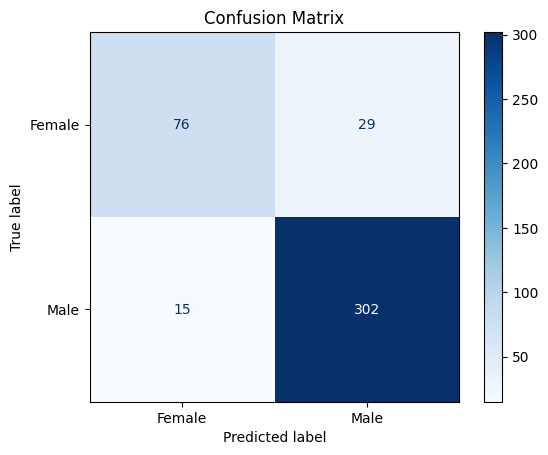

In [21]:
# 📌 Convert validation labels from TensorFlow tensor to a NumPy array and flatten to 1D
y_true = val_labels.numpy().flatten()

# 📊 Plot the confusion matrix to visualize model performance across classes
plot_confusion_matrix(y_true, y_pred)


### Scores

In [20]:
from sklearn.metrics import classification_report

# 🧾 Generate a detailed classification report (precision, recall, F1-score, and support)
# for both classes: Female (label 0) and Male (label 1)
print(classification_report(y_true, y_pred, target_names=["Female", "Male"]))


              precision    recall  f1-score   support

      Female       0.84      0.72      0.78       105
        Male       0.91      0.95      0.93       317

    accuracy                           0.90       422
   macro avg       0.87      0.84      0.85       422
weighted avg       0.89      0.90      0.89       422



### ADD TITLE

In [22]:
# 💾 Save the trained model architecture, weights, and optimizer state to an HDF5 file
model.save("ResGenderNet.h5")